In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import copy
import torch
%matplotlib inline

In [2]:
! pip install torch

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
!pip install -q transformers flash_attn timm einops peft

In [4]:
# @title Imports

import io
import os
import re
import json
import torch
import html
import base64
import itertools

import numpy as np
#import supervision as sv

#from google.colab import userdata
from IPython.core.display import display, HTML
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
from PIL import Image
#from roboflow import Roboflow

/tmp/ipykernel_23/1696402682.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [5]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import copy
import torch
%matplotlib inline

model_id = "microsoft/Florence-2-large-ft"
REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large-ft:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large-ft:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
#!unzip /content/dataset.zip

In [7]:
# @title Define `CaptioningDataset` class

class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class CaptioningDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = "<MORE_DETAILED_CAPTION>"
        suffix = data['suffix']
        return prefix, suffix, image

In [8]:
# @title Initiate `CaptioningDataset` and `DataLoader` for train and validation subsets

BATCH_SIZE = 2
NUM_WORKERS = 0

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

train_dataset = CaptioningDataset(
    jsonl_file_path = "/kaggle/input/baselinedataset/root-canal-captioning_baseline/train/preprocessed_train.jsonl",
    image_directory_path = "/kaggle/input/baselinedataset/root-canal-captioning_baseline/train"
)
val_dataset = CaptioningDataset(
    jsonl_file_path = "/kaggle/input/baselinedataset/root-canal-captioning_baseline/valid/preprocessed_valid.jsonl",
    image_directory_path = "/kaggle/input/baselinedataset/root-canal-captioning_baseline/valid"
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

In [9]:
# @title Setup LoRA Florence-2 model

config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"],
    task_type="CAUSAL_LM",
    lora_dropout=0.5,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
    revision=REVISION
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 4,133,576 || all params: 826,827,464 || trainable%: 0.4999


In [10]:
torch.cuda.empty_cache()

In [11]:
model = model.to(torch.float32)


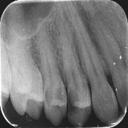
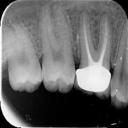
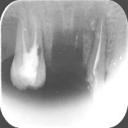
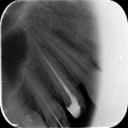

In [12]:
from PIL import Image
import io
import base64
import json
import html
from IPython.display import display, HTML

def render_inline(image: Image.Image, resize=(128, 128)):
    """Convert image into inline html."""
    image = image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"

def render_example(image: Image.Image, caption: str):
    """Render image and caption as HTML."""
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center;">
    <img style="width:256px; height:256px;" src="{render_inline(image, resize=(128, 128))}" />
    <p style="width:512px; margin:10px; font-size:small;">{html.escape(caption)}</p>
</div>
"""

def render_inference_results(model, dataset: CaptioningDataset, count: int):
    html_out = ""
    count = min(count, len(dataset))
    for i in range(count):
        image, data = dataset.dataset[i]
        prefix = "<MORE_DETAILED_CAPTION>"
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        caption = generated_text.strip()  # Process and clean up the generated text
        html_out += render_example(image, caption)

    display(HTML(html_out))

# Run the updated function to display image captions
render_inference_results(peft_model, val_dataset, 4)


In [13]:
import os
import torch
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import AdamW, get_scheduler

def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    # Initialize GradScaler for mixed precision training
    scaler = GradScaler()

    # Lists to store losses
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            input_ids = inputs["input_ids"].to(DEVICE)
            pixel_values = inputs["pixel_values"].to(DEVICE)
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                truncation=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            # Mixed precision training
            with autocast():
                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            lr_scheduler.step()

            train_loss += loss.item()

            # Clear GPU cache
            torch.cuda.empty_cache()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch + 1}: Average Training Loss: {avg_train_loss}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                input_ids = inputs["input_ids"].to(DEVICE)
                pixel_values = inputs["pixel_values"].to(DEVICE)
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    truncation=True,
                    return_token_type_ids=False
                ).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            print(f"Epoch {epoch + 1}: Average Validation Loss: {avg_val_loss}")

            # Render inference results for validation data
            render_inference_results(model, val_loader.dataset, 6)

        # Save model and processor checkpoint
        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)

    # Plot the loss curves
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.savefig('loss_curves.png')  # Save the plot as a PNG file
    plt.show()


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/tmp/ipykernel_23/2081242548.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training Epoch 1/100:   0%|          | 0/81 [00:00<?, ?it/s]/tmp/ipykernel_23/2081242548.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training Epoch 1/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 1: Average Training Loss: 1.135527048765877


Validation Epoch 1/100: 100%|██████████| 70/70 [00:51<00:00,  1.36it/s]


Epoch 1: Average Validation Loss: 0.4614608705043793



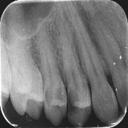
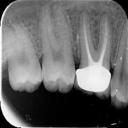
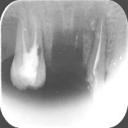
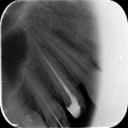
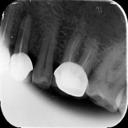
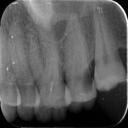

/opt/conda/lib/python3.10/site-packages/peft/utils/save_and_load.py:227: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
Training Epoch 2/100: 100%|██████████| 81/81 [02:40<00:00,  1.99s/it]


Epoch 2: Average Training Loss: 0.5684110119386956


Validation Epoch 2/100: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]


Epoch 2: Average Validation Loss: 0.3968496825013842



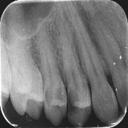
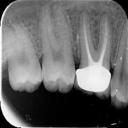
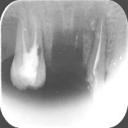
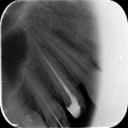
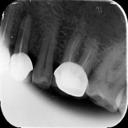
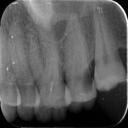

Training Epoch 3/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 3: Average Training Loss: 0.5340050600561095


Validation Epoch 3/100: 100%|██████████| 70/70 [00:50<00:00,  1.37it/s]


Epoch 3: Average Validation Loss: 0.5275474171553339



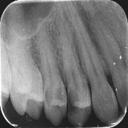
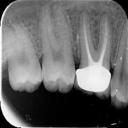
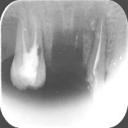
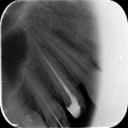
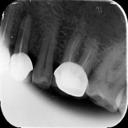
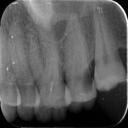

Training Epoch 4/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 4: Average Training Loss: 0.8931816625006405


Validation Epoch 4/100: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]


Epoch 4: Average Validation Loss: 0.49188077534948077



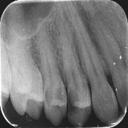
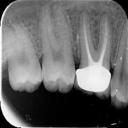
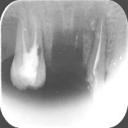
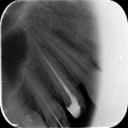
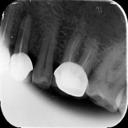
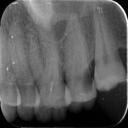

Training Epoch 5/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 5: Average Training Loss: 0.5851643379823661


Validation Epoch 5/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 5: Average Validation Loss: 0.43980773772512166



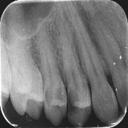
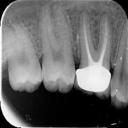
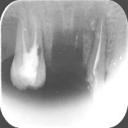
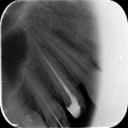
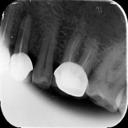
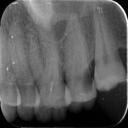

Training Epoch 6/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 6: Average Training Loss: 0.4756887334364432


Validation Epoch 6/100: 100%|██████████| 70/70 [00:50<00:00,  1.37it/s]


Epoch 6: Average Validation Loss: 0.4459885586585317



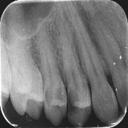
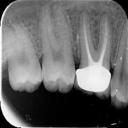
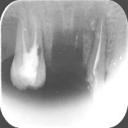
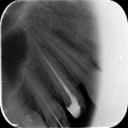
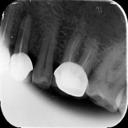
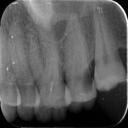

Training Epoch 7/100: 100%|██████████| 81/81 [02:40<00:00,  1.99s/it]


Epoch 7: Average Training Loss: 0.42234530456272174


Validation Epoch 7/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 7: Average Validation Loss: 0.3637553300176348



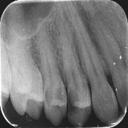
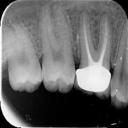
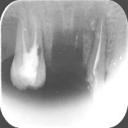
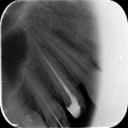
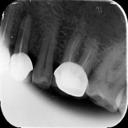
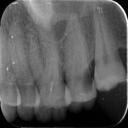

Training Epoch 8/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 8: Average Training Loss: 0.3841499090194702


Validation Epoch 8/100: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]


Epoch 8: Average Validation Loss: 0.4178217209875584



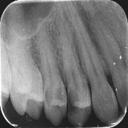
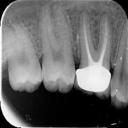
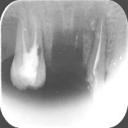
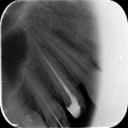
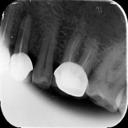
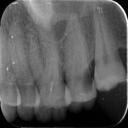

Training Epoch 9/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 9: Average Training Loss: 0.39048711992340324


Validation Epoch 9/100: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]


Epoch 9: Average Validation Loss: 0.4044970893434116



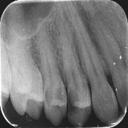
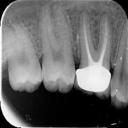
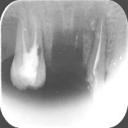
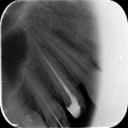
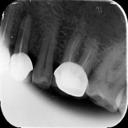
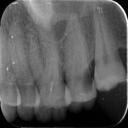

Training Epoch 10/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 10: Average Training Loss: 0.3670895838259179


Validation Epoch 10/100: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]


Epoch 10: Average Validation Loss: 0.35225405033145635



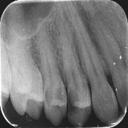
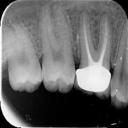
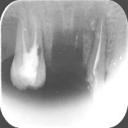
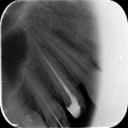
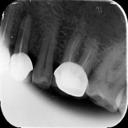
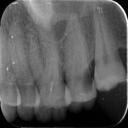

Training Epoch 11/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 11: Average Training Loss: 0.33326253092583313


Validation Epoch 11/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 11: Average Validation Loss: 0.3782771532024656



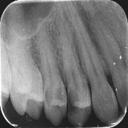
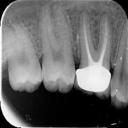
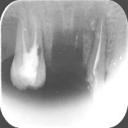
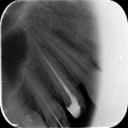
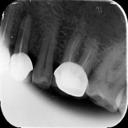
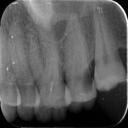

Training Epoch 12/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 12: Average Training Loss: 0.336800661811858


Validation Epoch 12/100: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]


Epoch 12: Average Validation Loss: 0.3772398972085544



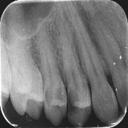
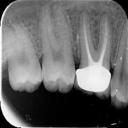
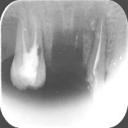
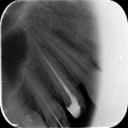
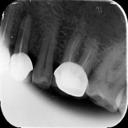
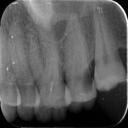

Training Epoch 13/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 13: Average Training Loss: 0.32754160712162655


Validation Epoch 13/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 13: Average Validation Loss: 0.3436484116528715



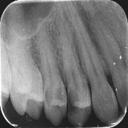
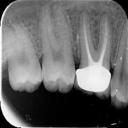
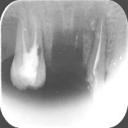
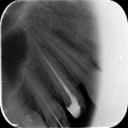
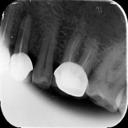
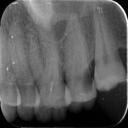

Training Epoch 14/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 14: Average Training Loss: 0.32013618421775325


Validation Epoch 14/100: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]


Epoch 14: Average Validation Loss: 0.36433315032294816



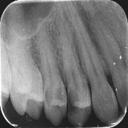
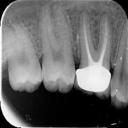
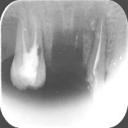
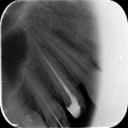
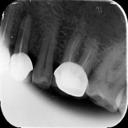
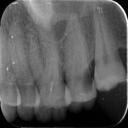

Training Epoch 15/100: 100%|██████████| 81/81 [02:39<00:00,  1.97s/it]


Epoch 15: Average Training Loss: 0.3137110789065008


Validation Epoch 15/100: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]


Epoch 15: Average Validation Loss: 0.33421477749943734



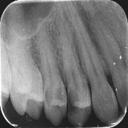
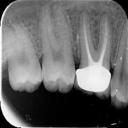
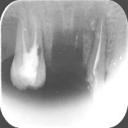
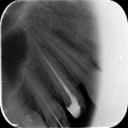
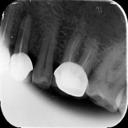
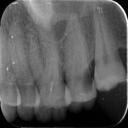

Training Epoch 16/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 16: Average Training Loss: 0.3236606866121292


Validation Epoch 16/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 16: Average Validation Loss: 0.3748485527932644



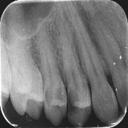
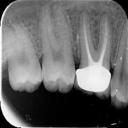
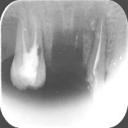
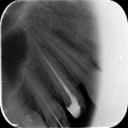
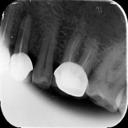
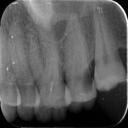

Training Epoch 17/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 17: Average Training Loss: 0.339015034245856


Validation Epoch 17/100: 100%|██████████| 70/70 [00:51<00:00,  1.36it/s]


Epoch 17: Average Validation Loss: 0.43048321860177174



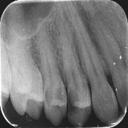
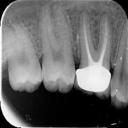
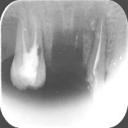
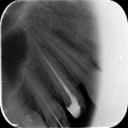
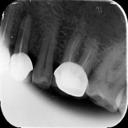
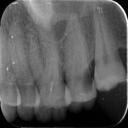

Training Epoch 18/100: 100%|██████████| 81/81 [02:41<00:00,  2.00s/it]


Epoch 18: Average Training Loss: 0.3140340543087618


Validation Epoch 18/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 18: Average Validation Loss: 0.4350663470370429



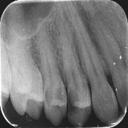
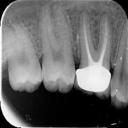
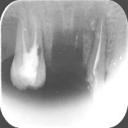
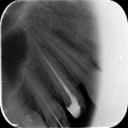
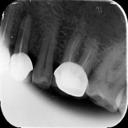
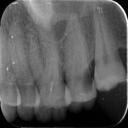

Training Epoch 19/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 19: Average Training Loss: 0.30017056592084745


Validation Epoch 19/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 19: Average Validation Loss: 0.35226305925420354



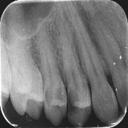
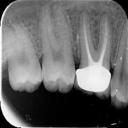
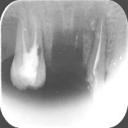
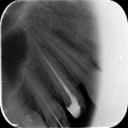
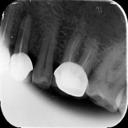
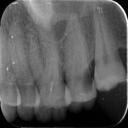

Training Epoch 20/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 20: Average Training Loss: 0.2974234379735994


Validation Epoch 20/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 20: Average Validation Loss: 0.3724751465022564



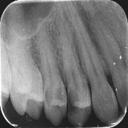
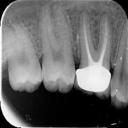
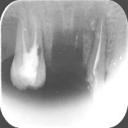
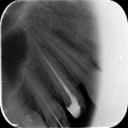
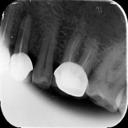
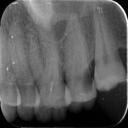

Training Epoch 21/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 21: Average Training Loss: 0.2857066936514996


Validation Epoch 21/100: 100%|██████████| 70/70 [00:51<00:00,  1.36it/s]


Epoch 21: Average Validation Loss: 0.3579455504459994



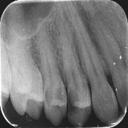
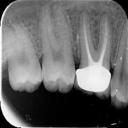
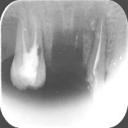
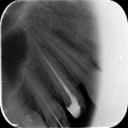
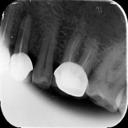
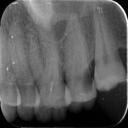

Training Epoch 22/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 22: Average Training Loss: 0.27812057034468946


Validation Epoch 22/100: 100%|██████████| 70/70 [00:50<00:00,  1.37it/s]


Epoch 22: Average Validation Loss: 0.36009216180869513



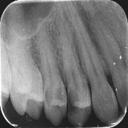
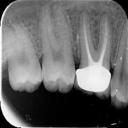
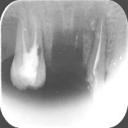
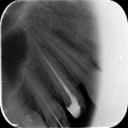
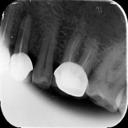
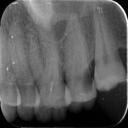

Training Epoch 23/100: 100%|██████████| 81/81 [02:40<00:00,  1.99s/it]


Epoch 23: Average Training Loss: 0.2898909343337571


Validation Epoch 23/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 23: Average Validation Loss: 0.3931969432958535



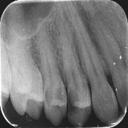
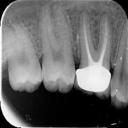
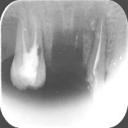
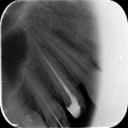
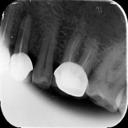
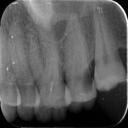

Training Epoch 24/100: 100%|██████████| 81/81 [02:41<00:00,  2.00s/it]


Epoch 24: Average Training Loss: 0.26705180784618415


Validation Epoch 24/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 24: Average Validation Loss: 0.36807606018015315



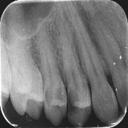
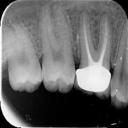
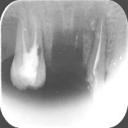
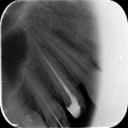
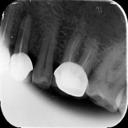
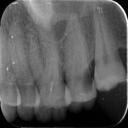

Training Epoch 25/100: 100%|██████████| 81/81 [02:41<00:00,  2.00s/it]


Epoch 25: Average Training Loss: 0.26436743416168074


Validation Epoch 25/100: 100%|██████████| 70/70 [00:51<00:00,  1.36it/s]


Epoch 25: Average Validation Loss: 0.35551699580890794



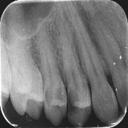
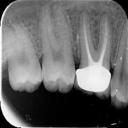
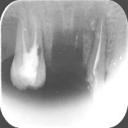
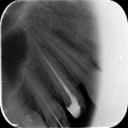
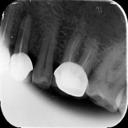
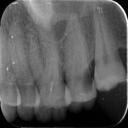

Training Epoch 26/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 26: Average Training Loss: 0.2569143439148679


Validation Epoch 26/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 26: Average Validation Loss: 0.4112341945724828



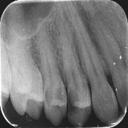
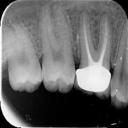
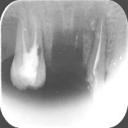
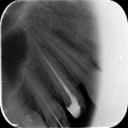
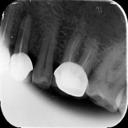
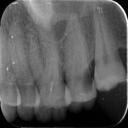

Training Epoch 27/100: 100%|██████████| 81/81 [02:41<00:00,  2.00s/it]


Epoch 27: Average Training Loss: 0.25640088972854025


Validation Epoch 27/100: 100%|██████████| 70/70 [00:51<00:00,  1.36it/s]


Epoch 27: Average Validation Loss: 0.35860137886234694



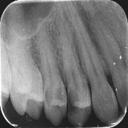
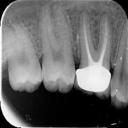
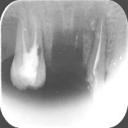
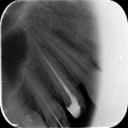
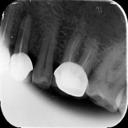
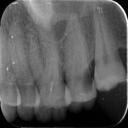

Training Epoch 28/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 28: Average Training Loss: 0.2518441796670725


Validation Epoch 28/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 28: Average Validation Loss: 0.33599245441811426



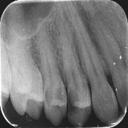
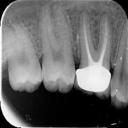
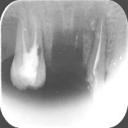
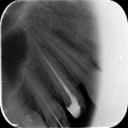
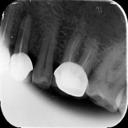
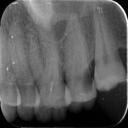

Training Epoch 29/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 29: Average Training Loss: 0.23878397774181248


Validation Epoch 29/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 29: Average Validation Loss: 0.31937206940991536



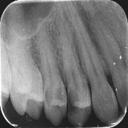
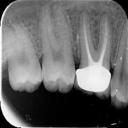
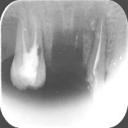
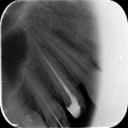
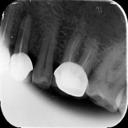
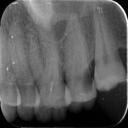

Training Epoch 30/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 30: Average Training Loss: 0.24168240458325105


Validation Epoch 30/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 30: Average Validation Loss: 0.3324848544384752



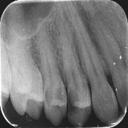
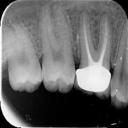
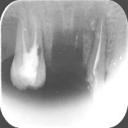
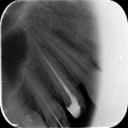
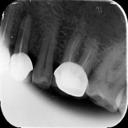
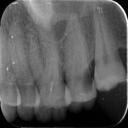

Training Epoch 31/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 31: Average Training Loss: 0.24221153520507577


Validation Epoch 31/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 31: Average Validation Loss: 0.33099751217024664



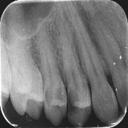
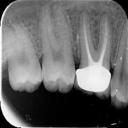
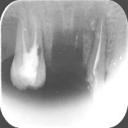
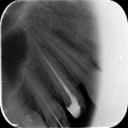
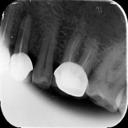
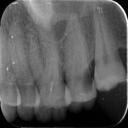

Training Epoch 32/100: 100%|██████████| 81/81 [02:40<00:00,  1.99s/it]


Epoch 32: Average Training Loss: 0.24796818849849112


Validation Epoch 32/100: 100%|██████████| 70/70 [00:50<00:00,  1.37it/s]


Epoch 32: Average Validation Loss: 0.33657580986618996



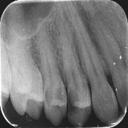
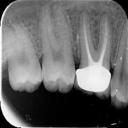
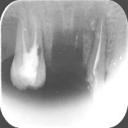
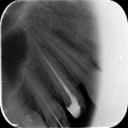
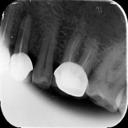
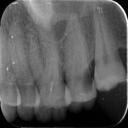

Training Epoch 33/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 33: Average Training Loss: 0.2457720250075246


Validation Epoch 33/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 33: Average Validation Loss: 0.4423269695469311



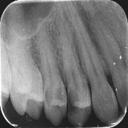
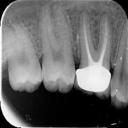
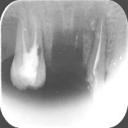
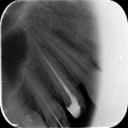
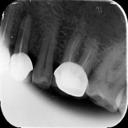
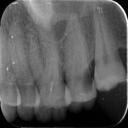

Training Epoch 34/100: 100%|██████████| 81/81 [02:40<00:00,  1.99s/it]


Epoch 34: Average Training Loss: 0.2582608187272225


Validation Epoch 34/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 34: Average Validation Loss: 0.3565146857074329



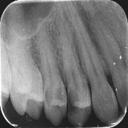
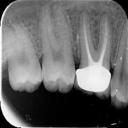
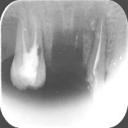
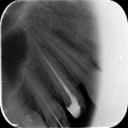
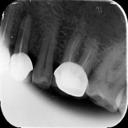
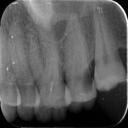

Training Epoch 35/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 35: Average Training Loss: 0.32774265625594573


Validation Epoch 35/100: 100%|██████████| 70/70 [00:51<00:00,  1.36it/s]


Epoch 35: Average Validation Loss: 0.39000644886067937



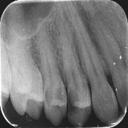
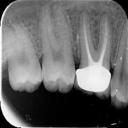
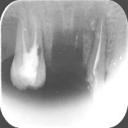
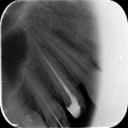
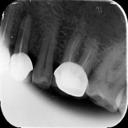
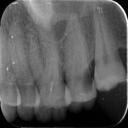

Training Epoch 36/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 36: Average Training Loss: 0.28738299039778886


Validation Epoch 36/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 36: Average Validation Loss: 0.410738979279995



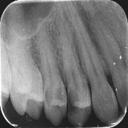
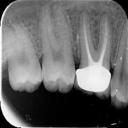
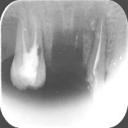
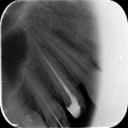
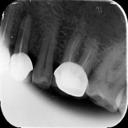
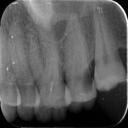

Training Epoch 37/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 37: Average Training Loss: 0.2841238722573092


Validation Epoch 37/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 37: Average Validation Loss: 0.35937405665005956



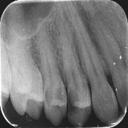
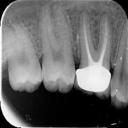
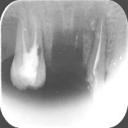
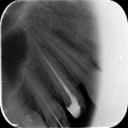
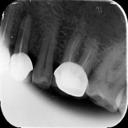
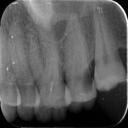

Training Epoch 38/100: 100%|██████████| 81/81 [02:41<00:00,  2.00s/it]


Epoch 38: Average Training Loss: 0.26924349901116923


Validation Epoch 38/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 38: Average Validation Loss: 0.36822905678834233



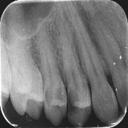
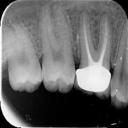
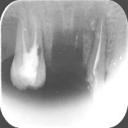
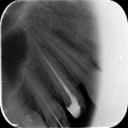
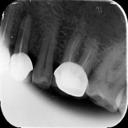
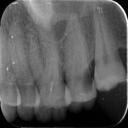

Training Epoch 39/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 39: Average Training Loss: 0.2550958347633297


Validation Epoch 39/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 39: Average Validation Loss: 0.35050591517771995



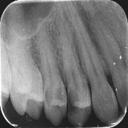
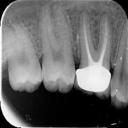
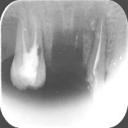
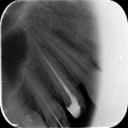
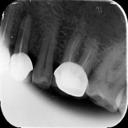
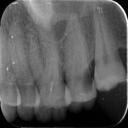

Training Epoch 40/100: 100%|██████████| 81/81 [02:40<00:00,  1.99s/it]


Epoch 40: Average Training Loss: 0.24053155635426074


Validation Epoch 40/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 40: Average Validation Loss: 0.35117160379886625



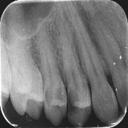
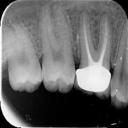
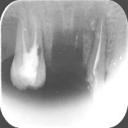
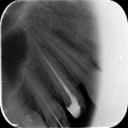
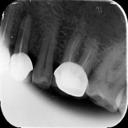
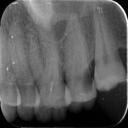

Training Epoch 41/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 41: Average Training Loss: 0.2174724496809053


Validation Epoch 41/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 41: Average Validation Loss: 0.3376401805984122



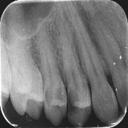
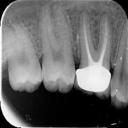
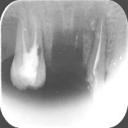
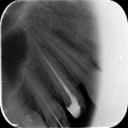
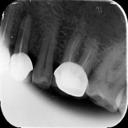
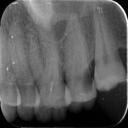

Training Epoch 42/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 42: Average Training Loss: 0.23006978138913342


Validation Epoch 42/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 42: Average Validation Loss: 0.35450237233723914



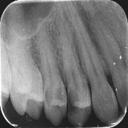
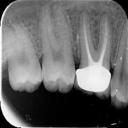
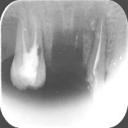
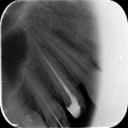
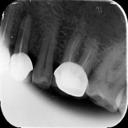
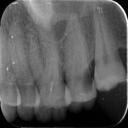

Training Epoch 43/100: 100%|██████████| 81/81 [02:40<00:00,  1.99s/it]


Epoch 43: Average Training Loss: 0.22109841707128067


Validation Epoch 43/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 43: Average Validation Loss: 0.3439730627196176



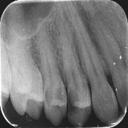
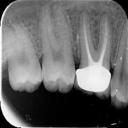
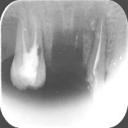
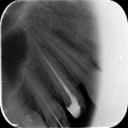
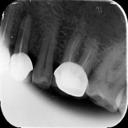
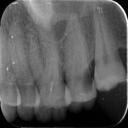

Training Epoch 44/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 44: Average Training Loss: 0.20700149247307836


Validation Epoch 44/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 44: Average Validation Loss: 0.3714110862995897



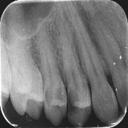
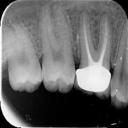
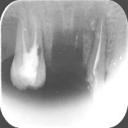
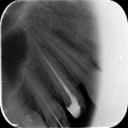
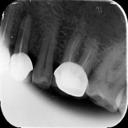
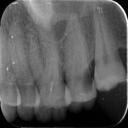

Training Epoch 45/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 45: Average Training Loss: 0.20393682892123857


Validation Epoch 45/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 45: Average Validation Loss: 0.36830114371010236



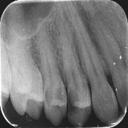
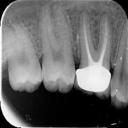
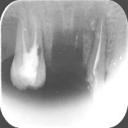
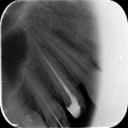
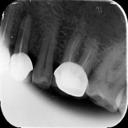
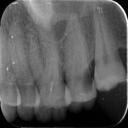

Training Epoch 46/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 46: Average Training Loss: 0.1979083025161131


Validation Epoch 46/100: 100%|██████████| 70/70 [00:50<00:00,  1.37it/s]


Epoch 46: Average Validation Loss: 0.3917401857674122



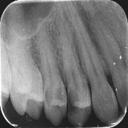
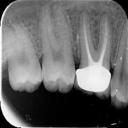
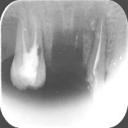
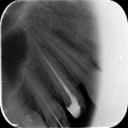
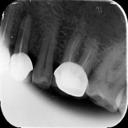
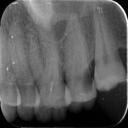

Training Epoch 47/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 47: Average Training Loss: 0.19858647128682078


Validation Epoch 47/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 47: Average Validation Loss: 0.3346133191138506



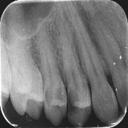
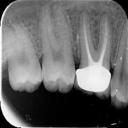
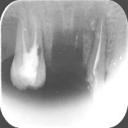
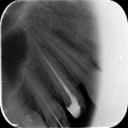
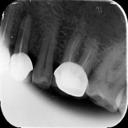
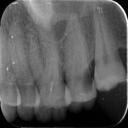

Training Epoch 48/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 48: Average Training Loss: 0.19450471366261257


Validation Epoch 48/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 48: Average Validation Loss: 0.34371370933949946



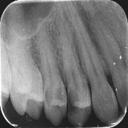
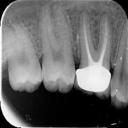
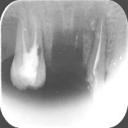
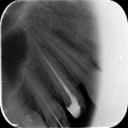
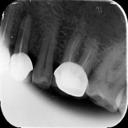
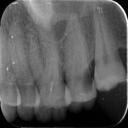

Training Epoch 49/100: 100%|██████████| 81/81 [02:40<00:00,  1.99s/it]


Epoch 49: Average Training Loss: 0.18182898303608835


Validation Epoch 49/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 49: Average Validation Loss: 0.35522613961781774



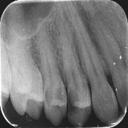
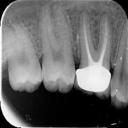
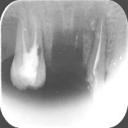
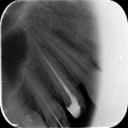
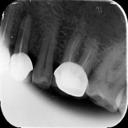
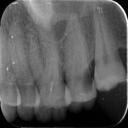

Training Epoch 50/100: 100%|██████████| 81/81 [02:40<00:00,  1.99s/it]


Epoch 50: Average Training Loss: 0.18366894438678835


Validation Epoch 50/100: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]


Epoch 50: Average Validation Loss: 0.335287904260414



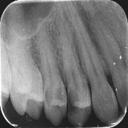
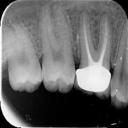
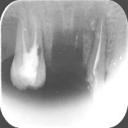
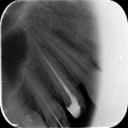
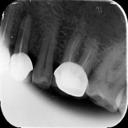
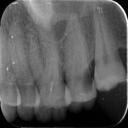

Training Epoch 51/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 51: Average Training Loss: 0.18135632809113572


Validation Epoch 51/100: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]


Epoch 51: Average Validation Loss: 0.33981207140854425



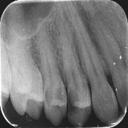
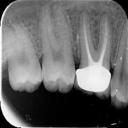
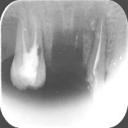
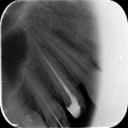
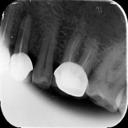
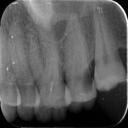

Training Epoch 52/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 52: Average Training Loss: 0.17125559441837263


Validation Epoch 52/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 52: Average Validation Loss: 0.34911332875490186



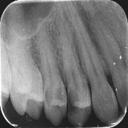
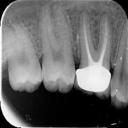
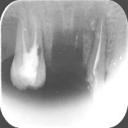
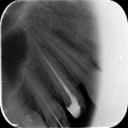
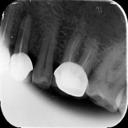
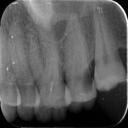

Training Epoch 53/100: 100%|██████████| 81/81 [02:40<00:00,  1.99s/it]


Epoch 53: Average Training Loss: 0.17172463872918375


Validation Epoch 53/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 53: Average Validation Loss: 0.35478832870721816



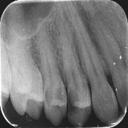
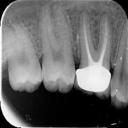
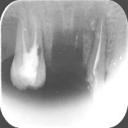
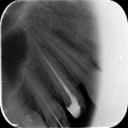
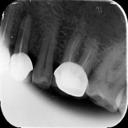
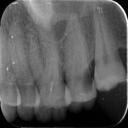

Training Epoch 54/100: 100%|██████████| 81/81 [02:40<00:00,  1.99s/it]


Epoch 54: Average Training Loss: 0.1618610968652331


Validation Epoch 54/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 54: Average Validation Loss: 0.34563060072915897



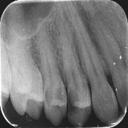
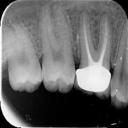
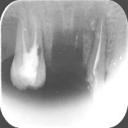
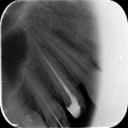
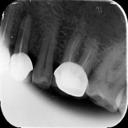
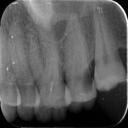

Training Epoch 55/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 55: Average Training Loss: 0.16514932805741275


Validation Epoch 55/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 55: Average Validation Loss: 0.38782878922564645



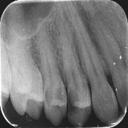
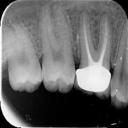
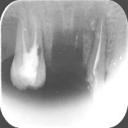
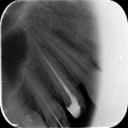
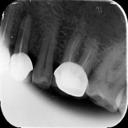
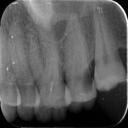

Training Epoch 56/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 56: Average Training Loss: 0.16985577211519817


Validation Epoch 56/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 56: Average Validation Loss: 0.3321771367319993



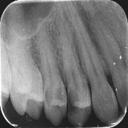
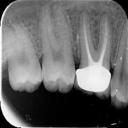
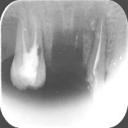
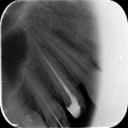
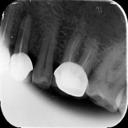
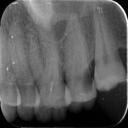

Training Epoch 57/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 57: Average Training Loss: 0.16426269572090219


Validation Epoch 57/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 57: Average Validation Loss: 0.3314004044979811



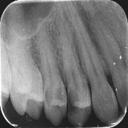
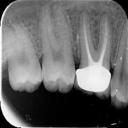
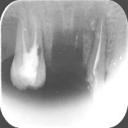
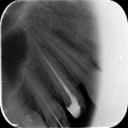
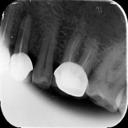
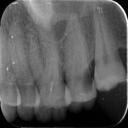

Training Epoch 58/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 58: Average Training Loss: 0.16150780058937309


Validation Epoch 58/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 58: Average Validation Loss: 0.3523506908544472



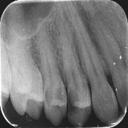
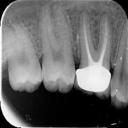
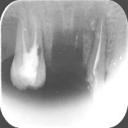
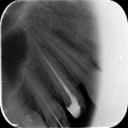
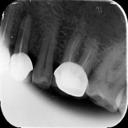
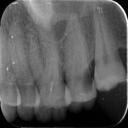

Training Epoch 59/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 59: Average Training Loss: 0.14981327808381598


Validation Epoch 59/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 59: Average Validation Loss: 0.32280822976359297



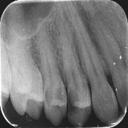
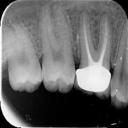
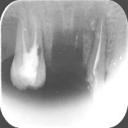
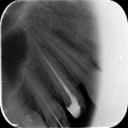
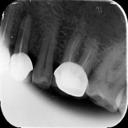
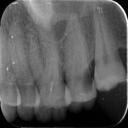

Training Epoch 60/100: 100%|██████████| 81/81 [02:40<00:00,  1.99s/it]


Epoch 60: Average Training Loss: 0.15724046795088567


Validation Epoch 60/100: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]


Epoch 60: Average Validation Loss: 0.3494443593280656



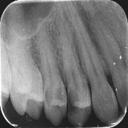
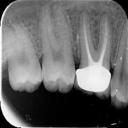
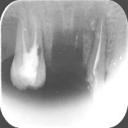
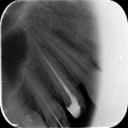
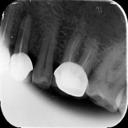
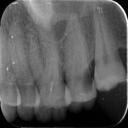

Training Epoch 61/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 61: Average Training Loss: 0.15020275309129996


Validation Epoch 61/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 61: Average Validation Loss: 0.3498051829636097



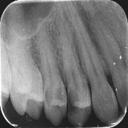
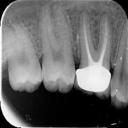
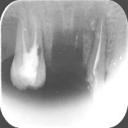
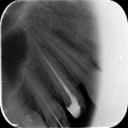
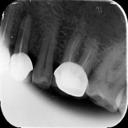
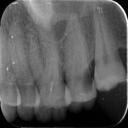

Training Epoch 62/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 62: Average Training Loss: 0.15117611055388863


Validation Epoch 62/100: 100%|██████████| 70/70 [00:50<00:00,  1.37it/s]


Epoch 62: Average Validation Loss: 0.3322887628206185



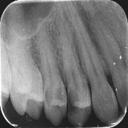
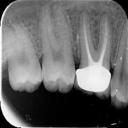
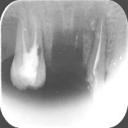
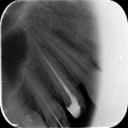
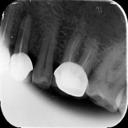
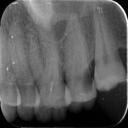

Training Epoch 63/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 63: Average Training Loss: 0.1429632754513511


Validation Epoch 63/100: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]


Epoch 63: Average Validation Loss: 0.333907780370542



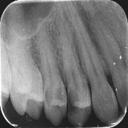
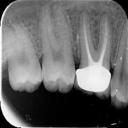
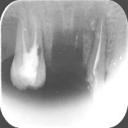
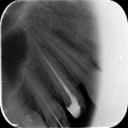
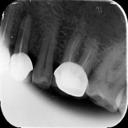
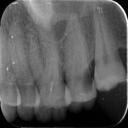

Training Epoch 64/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 64: Average Training Loss: 0.1399418255429209


Validation Epoch 64/100: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]


Epoch 64: Average Validation Loss: 0.3466800438506263



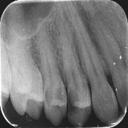
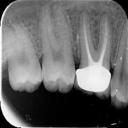
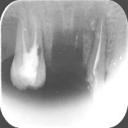
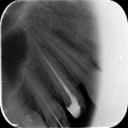
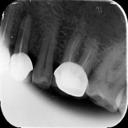
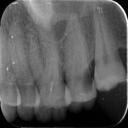

Training Epoch 65/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 65: Average Training Loss: 0.1436935371638816


Validation Epoch 65/100: 100%|██████████| 70/70 [00:50<00:00,  1.37it/s]


Epoch 65: Average Validation Loss: 0.32778274821383613



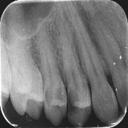
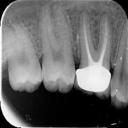
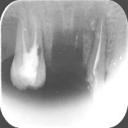
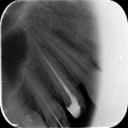
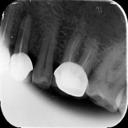
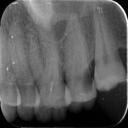

Training Epoch 66/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 66: Average Training Loss: 0.13563304274906346


Validation Epoch 66/100: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]


Epoch 66: Average Validation Loss: 0.32470934188791684



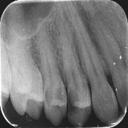
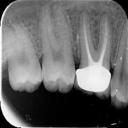
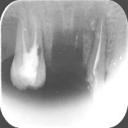
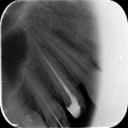
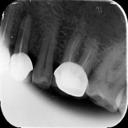
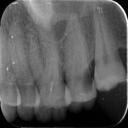

Training Epoch 67/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 67: Average Training Loss: 0.13247081439620184


Validation Epoch 67/100: 100%|██████████| 70/70 [00:50<00:00,  1.37it/s]


Epoch 67: Average Validation Loss: 0.3347556368580886



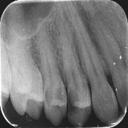
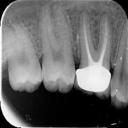
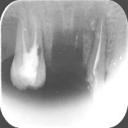
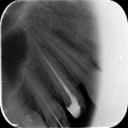
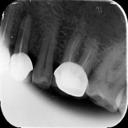
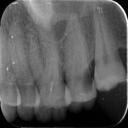

Training Epoch 68/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 68: Average Training Loss: 0.13167202744035073


Validation Epoch 68/100: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]


Epoch 68: Average Validation Loss: 0.3304948927568538



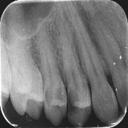
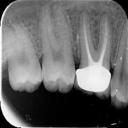
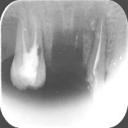
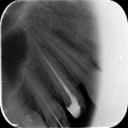
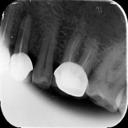
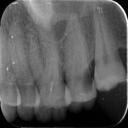

Training Epoch 69/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 69: Average Training Loss: 0.13040562466154865


Validation Epoch 69/100: 100%|██████████| 70/70 [00:50<00:00,  1.37it/s]


Epoch 69: Average Validation Loss: 0.3273083434573242



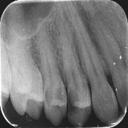
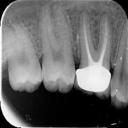
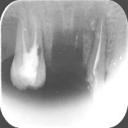
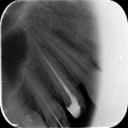
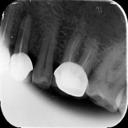
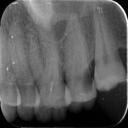

Training Epoch 70/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 70: Average Training Loss: 0.1301803946679021


Validation Epoch 70/100: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]


Epoch 70: Average Validation Loss: 0.31941751007522856



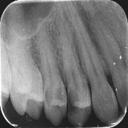
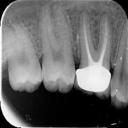
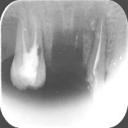
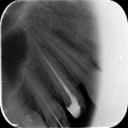
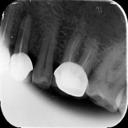
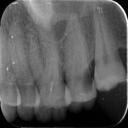

Training Epoch 71/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 71: Average Training Loss: 0.13472537443409732


Validation Epoch 71/100: 100%|██████████| 70/70 [00:50<00:00,  1.37it/s]


Epoch 71: Average Validation Loss: 0.339387095613139



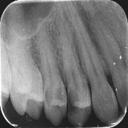
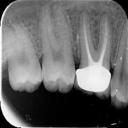
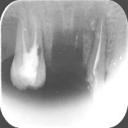
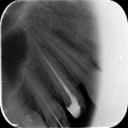
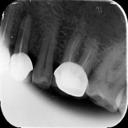
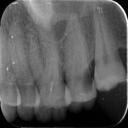

Training Epoch 72/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 72: Average Training Loss: 0.1290884247440615


Validation Epoch 72/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 72: Average Validation Loss: 0.33689516835979055



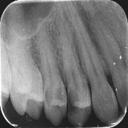
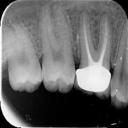
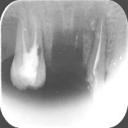
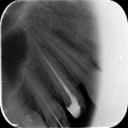
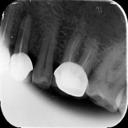
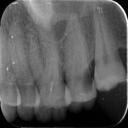

Training Epoch 73/100: 100%|██████████| 81/81 [02:40<00:00,  1.99s/it]


Epoch 73: Average Training Loss: 0.1245503997269236


Validation Epoch 73/100: 100%|██████████| 70/70 [00:51<00:00,  1.36it/s]


Epoch 73: Average Validation Loss: 0.34023538806608744



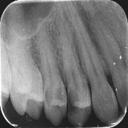
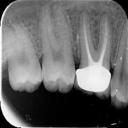
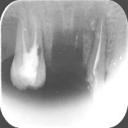
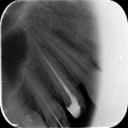
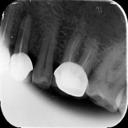
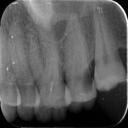

Training Epoch 74/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 74: Average Training Loss: 0.12760926334670297


Validation Epoch 74/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 74: Average Validation Loss: 0.38388661007796016



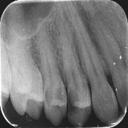
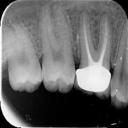
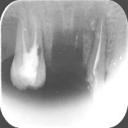
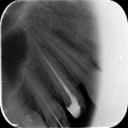
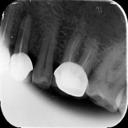
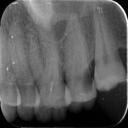

Training Epoch 75/100: 100%|██████████| 81/81 [02:40<00:00,  1.99s/it]


Epoch 75: Average Training Loss: 0.11876711355131349


Validation Epoch 75/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 75: Average Validation Loss: 0.32784097524625916



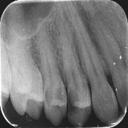
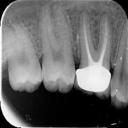
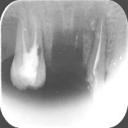
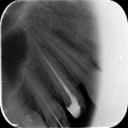
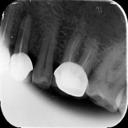
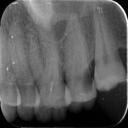

Training Epoch 76/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 76: Average Training Loss: 0.12015932299380686


Validation Epoch 76/100: 100%|██████████| 70/70 [00:50<00:00,  1.37it/s]


Epoch 76: Average Validation Loss: 0.3751912392675877



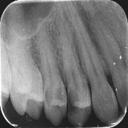
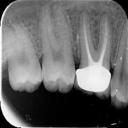
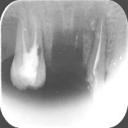
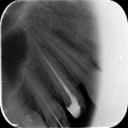
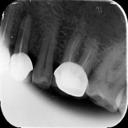
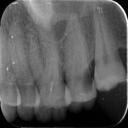

Training Epoch 77/100: 100%|██████████| 81/81 [02:40<00:00,  1.99s/it]


Epoch 77: Average Training Loss: 0.11756579255984154


Validation Epoch 77/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 77: Average Validation Loss: 0.3587101704307965



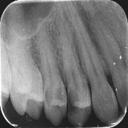
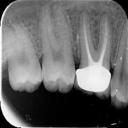
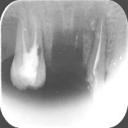
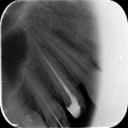
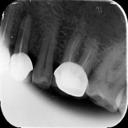
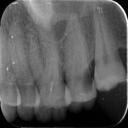

Training Epoch 78/100: 100%|██████████| 81/81 [02:40<00:00,  1.99s/it]


Epoch 78: Average Training Loss: 0.11539584186709957


Validation Epoch 78/100: 100%|██████████| 70/70 [00:50<00:00,  1.37it/s]


Epoch 78: Average Validation Loss: 0.3457255139414753



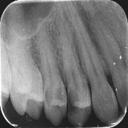
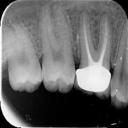
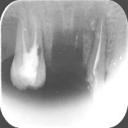
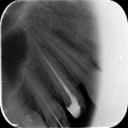
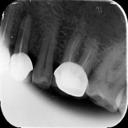
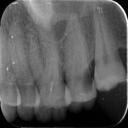

Training Epoch 79/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 79: Average Training Loss: 0.10869769979682234


Validation Epoch 79/100: 100%|██████████| 70/70 [00:50<00:00,  1.37it/s]


Epoch 79: Average Validation Loss: 0.33970772570797375



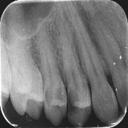
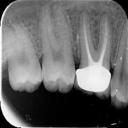
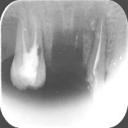
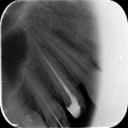
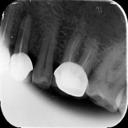
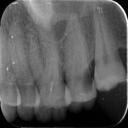

Training Epoch 80/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 80: Average Training Loss: 0.10891822224229943


Validation Epoch 80/100: 100%|██████████| 70/70 [00:50<00:00,  1.37it/s]


Epoch 80: Average Validation Loss: 0.36105279475450514



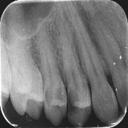
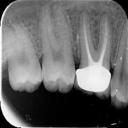
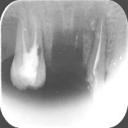
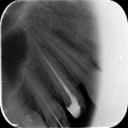
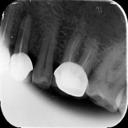
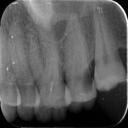

Training Epoch 81/100: 100%|██████████| 81/81 [02:40<00:00,  1.99s/it]


Epoch 81: Average Training Loss: 0.1059622955221085


Validation Epoch 81/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 81: Average Validation Loss: 0.3497404986194202



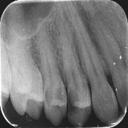
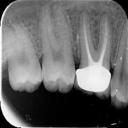
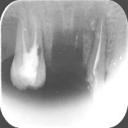
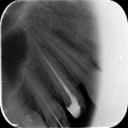
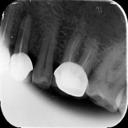
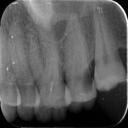

Training Epoch 82/100: 100%|██████████| 81/81 [02:40<00:00,  1.99s/it]


Epoch 82: Average Training Loss: 0.10479064329446834


Validation Epoch 82/100: 100%|██████████| 70/70 [00:50<00:00,  1.37it/s]


Epoch 82: Average Validation Loss: 0.34575609900057314



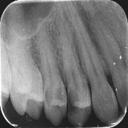
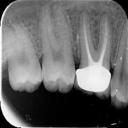
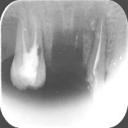
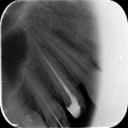
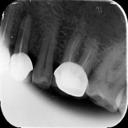
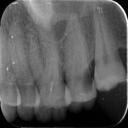

Training Epoch 83/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 83: Average Training Loss: 0.10087957122811565


Validation Epoch 83/100: 100%|██████████| 70/70 [00:50<00:00,  1.37it/s]


Epoch 83: Average Validation Loss: 0.34032870158553125



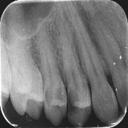
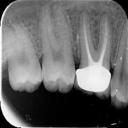
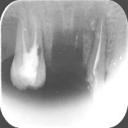
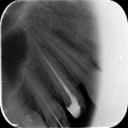
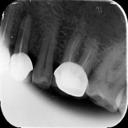
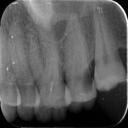

Training Epoch 84/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 84: Average Training Loss: 0.10528680323450654


Validation Epoch 84/100: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]


Epoch 84: Average Validation Loss: 0.33455270092402184



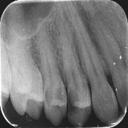
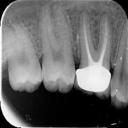
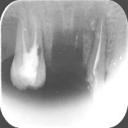
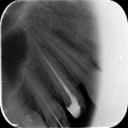
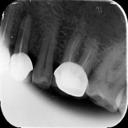
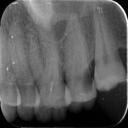

Training Epoch 85/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 85: Average Training Loss: 0.10495061960853176


Validation Epoch 85/100: 100%|██████████| 70/70 [00:50<00:00,  1.37it/s]


Epoch 85: Average Validation Loss: 0.34833230482680455



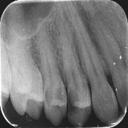
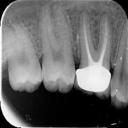
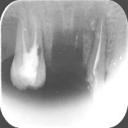
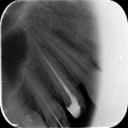
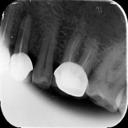
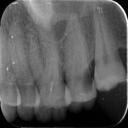

Training Epoch 86/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 86: Average Training Loss: 0.0982756759557459


Validation Epoch 86/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 86: Average Validation Loss: 0.34164696862655025



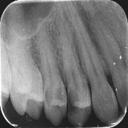
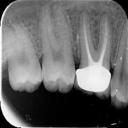
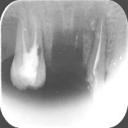
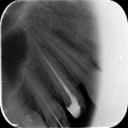
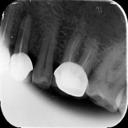
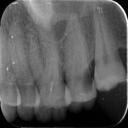

Training Epoch 87/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 87: Average Training Loss: 0.09999993999983058


Validation Epoch 87/100: 100%|██████████| 70/70 [00:50<00:00,  1.37it/s]


Epoch 87: Average Validation Loss: 0.3280467383031334



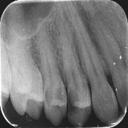
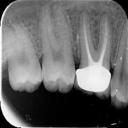
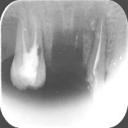
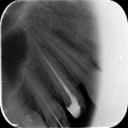
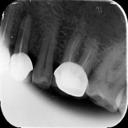
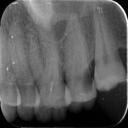

Training Epoch 88/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 88: Average Training Loss: 0.09908923759688566


Validation Epoch 88/100: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]


Epoch 88: Average Validation Loss: 0.33940483475370065



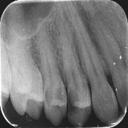
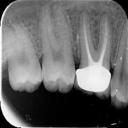
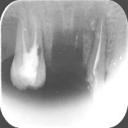
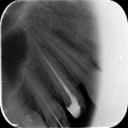
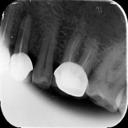
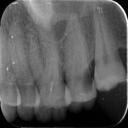

Training Epoch 89/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 89: Average Training Loss: 0.09878482458032208


Validation Epoch 89/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 89: Average Validation Loss: 0.3351290545825447



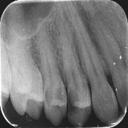
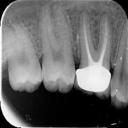
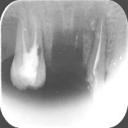
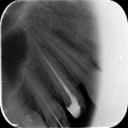
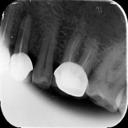
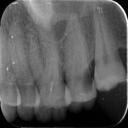

Training Epoch 90/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 90: Average Training Loss: 0.09631802270441879


Validation Epoch 90/100: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]


Epoch 90: Average Validation Loss: 0.3349957075502191



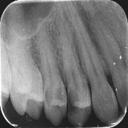
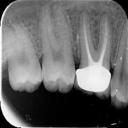
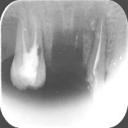
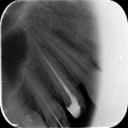
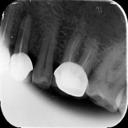
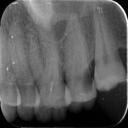

Training Epoch 91/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 91: Average Training Loss: 0.09531147198544608


Validation Epoch 91/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 91: Average Validation Loss: 0.3320167132786342



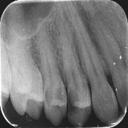
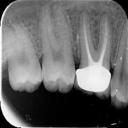
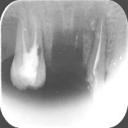
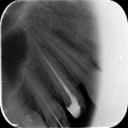
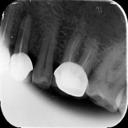
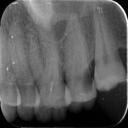

Training Epoch 92/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 92: Average Training Loss: 0.09257779587750081


Validation Epoch 92/100: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]


Epoch 92: Average Validation Loss: 0.3320932076977832



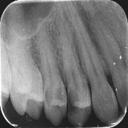
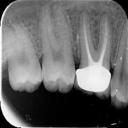
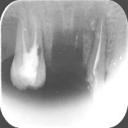
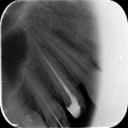
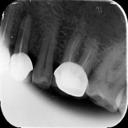
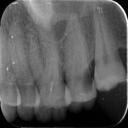

Training Epoch 93/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 93: Average Training Loss: 0.09390403187753242


Validation Epoch 93/100: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]


Epoch 93: Average Validation Loss: 0.32540922473583905



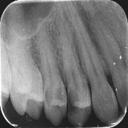
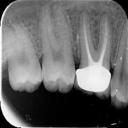
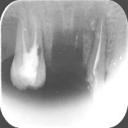
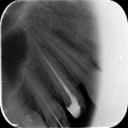
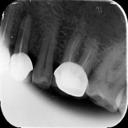
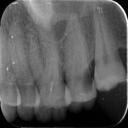

Training Epoch 94/100: 100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


Epoch 94: Average Training Loss: 0.08958150152071023


Validation Epoch 94/100: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]


Epoch 94: Average Validation Loss: 0.3307381059974432



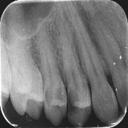
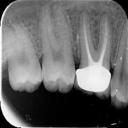
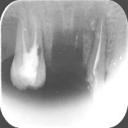
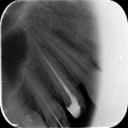
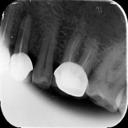
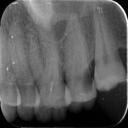

Training Epoch 95/100: 100%|██████████| 81/81 [02:39<00:00,  1.97s/it]


Epoch 95: Average Training Loss: 0.09496238862198812


Validation Epoch 95/100: 100%|██████████| 70/70 [00:50<00:00,  1.38it/s]


Epoch 95: Average Validation Loss: 0.330248060343521



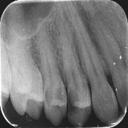
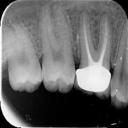
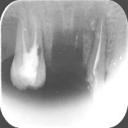
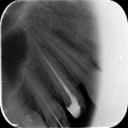
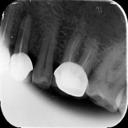
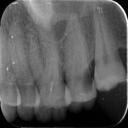

Training Epoch 96/100: 100%|██████████| 81/81 [02:40<00:00,  1.99s/it]


Epoch 96: Average Training Loss: 0.0888292309080745


Validation Epoch 96/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 96: Average Validation Loss: 0.3285979987787349



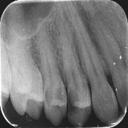
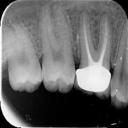
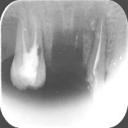
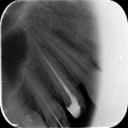
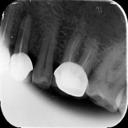
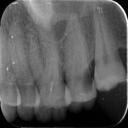

Training Epoch 97/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 97: Average Training Loss: 0.08474346149114916


Validation Epoch 97/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 97: Average Validation Loss: 0.3296556909701654



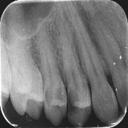
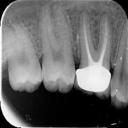
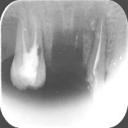
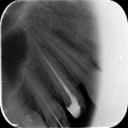
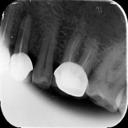
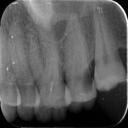

Training Epoch 98/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 98: Average Training Loss: 0.08347166216943736


Validation Epoch 98/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 98: Average Validation Loss: 0.33080268555453846



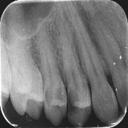
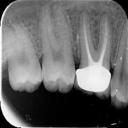
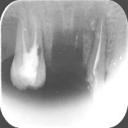
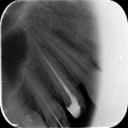
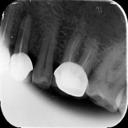
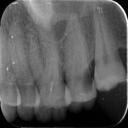

Training Epoch 99/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 99: Average Training Loss: 0.08524146464503841


Validation Epoch 99/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 99: Average Validation Loss: 0.3315656824303525



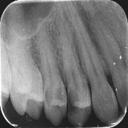
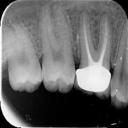
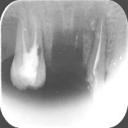
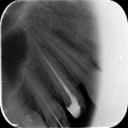
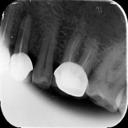
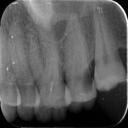

Training Epoch 100/100: 100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


Epoch 100: Average Training Loss: 0.08567810440321028


Validation Epoch 100/100: 100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


Epoch 100: Average Validation Loss: 0.3316025290638208



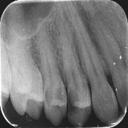
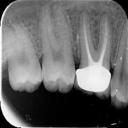
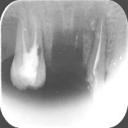
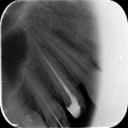
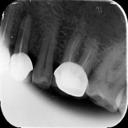
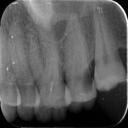

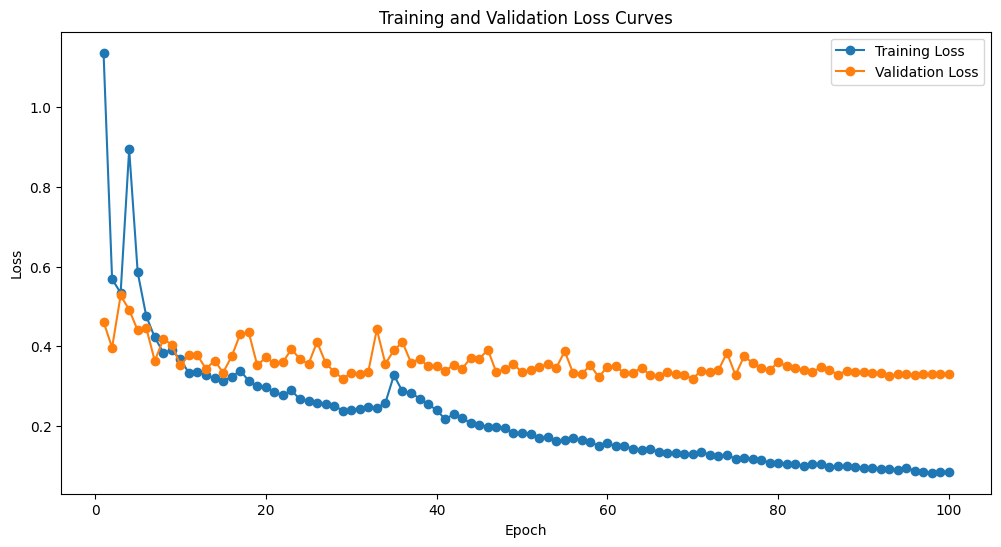

In [14]:
# Example usage
train_model(train_loader, val_loader, peft_model, processor, epochs=100, lr=1e-3)

In [15]:
"""import os
import torch
from transformers import AutoProcessor

# Specify the directory where the best model and processor were saved
output_dir = "/kaggle/working/model_checkpoints/best_model_epoch_3"

# Check if the directory exists
if not os.path.exists(output_dir):
    raise FileNotFoundError(f"The directory {output_dir} does not exist. Please check the path.")

# Reload the best model state dict
model = peft_model  # Ensure to define or import the correct model architecture used during training
model_path = os.path.join(output_dir, "model.pth")
model.load_state_dict(torch.load(model_path))
model.to(DEVICE)
model.eval()  # Set the model to evaluation mode


print(f"Successfully reloaded the best model and processor from best epoch.")
"""

'import os\nimport torch\nfrom transformers import AutoProcessor\n\n# Specify the directory where the best model and processor were saved\noutput_dir = "/kaggle/working/model_checkpoints/best_model_epoch_3"\n\n# Check if the directory exists\nif not os.path.exists(output_dir):\n    raise FileNotFoundError(f"The directory {output_dir} does not exist. Please check the path.")\n\n# Reload the best model state dict\nmodel = peft_model  # Ensure to define or import the correct model architecture used during training\nmodel_path = os.path.join(output_dir, "model.pth")\nmodel.load_state_dict(torch.load(model_path))\nmodel.to(DEVICE)\nmodel.eval()  # Set the model to evaluation mode\n\n\nprint(f"Successfully reloaded the best model and processor from best epoch.")\n'


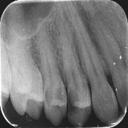
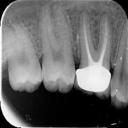
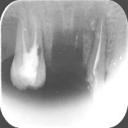
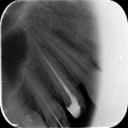
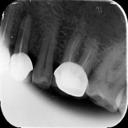
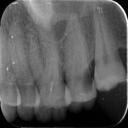
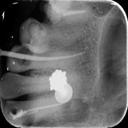
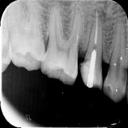
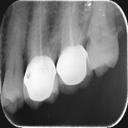
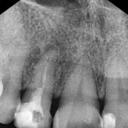
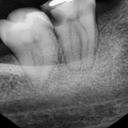
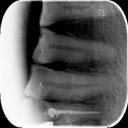
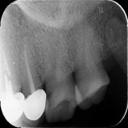
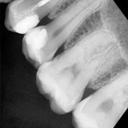
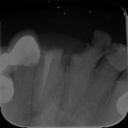
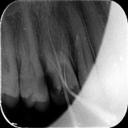
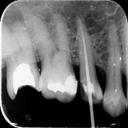
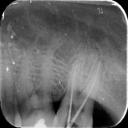
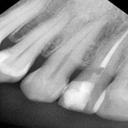
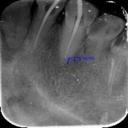
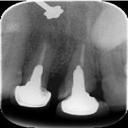
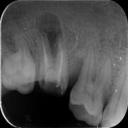
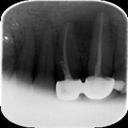
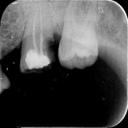
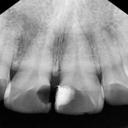
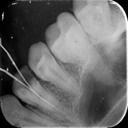
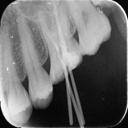
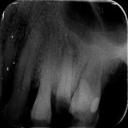
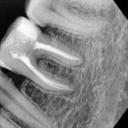
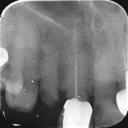
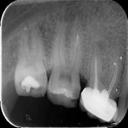
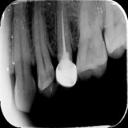
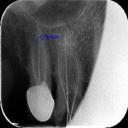
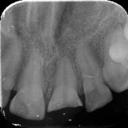
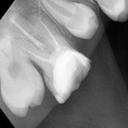
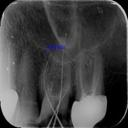
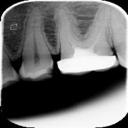
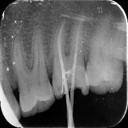
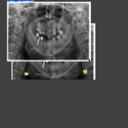
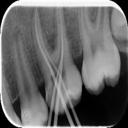
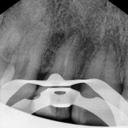
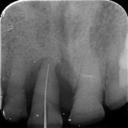
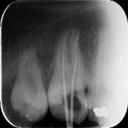
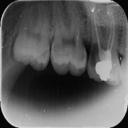
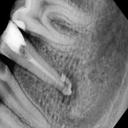
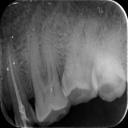
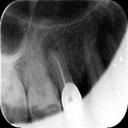
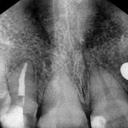
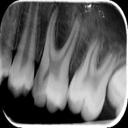
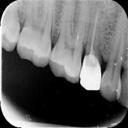
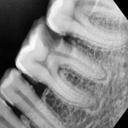
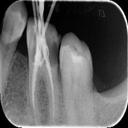
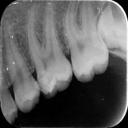
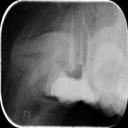
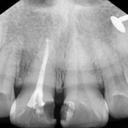
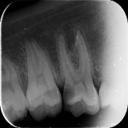
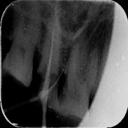
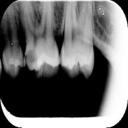
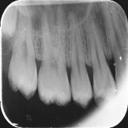
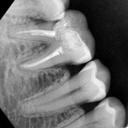
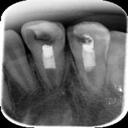
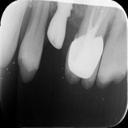
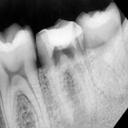
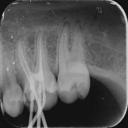
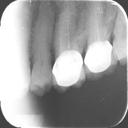
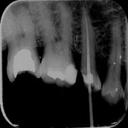
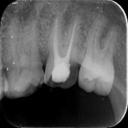
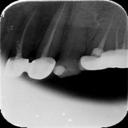
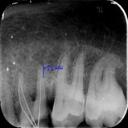
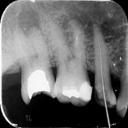
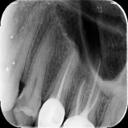
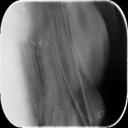
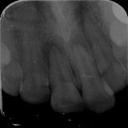
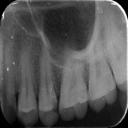
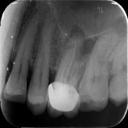
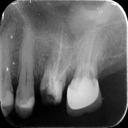
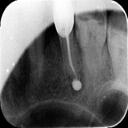
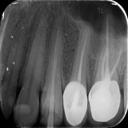
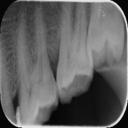
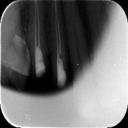
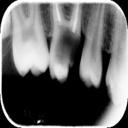
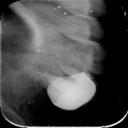
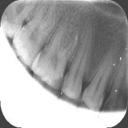
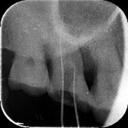
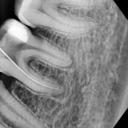
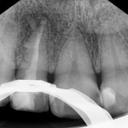
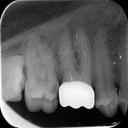
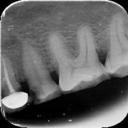
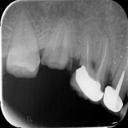
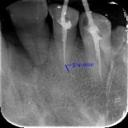
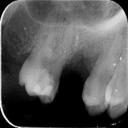
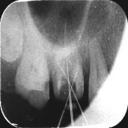
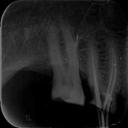
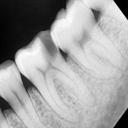
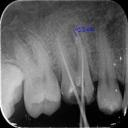
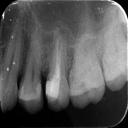
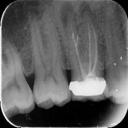
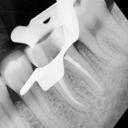
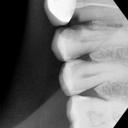
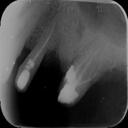
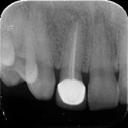
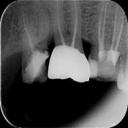
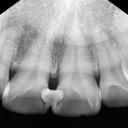
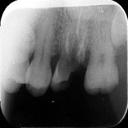
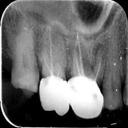
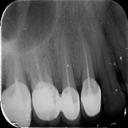
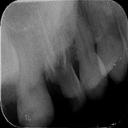
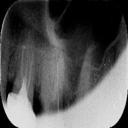
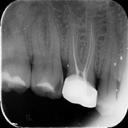
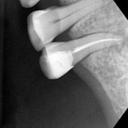
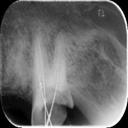
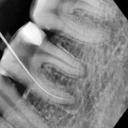
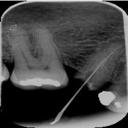
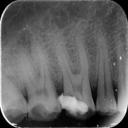
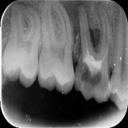
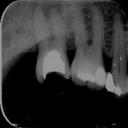
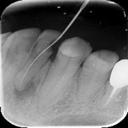
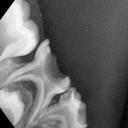
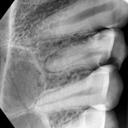
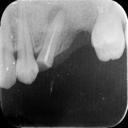
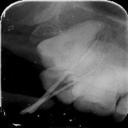
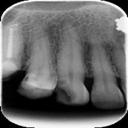
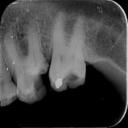
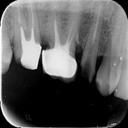
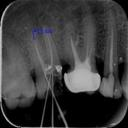
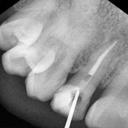
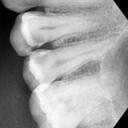
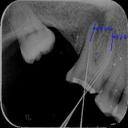
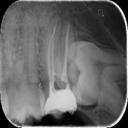
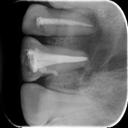
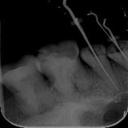
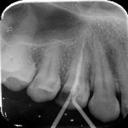
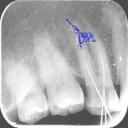
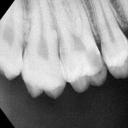
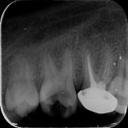
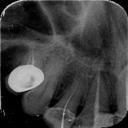
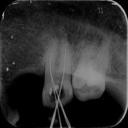
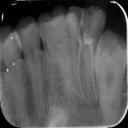
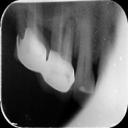

In [16]:
# Render inference results for validation data
render_inference_results(peft_model, val_loader.dataset, 139)

Inference: 100%|██████████| 70/70 [02:48<00:00,  2.40s/it]


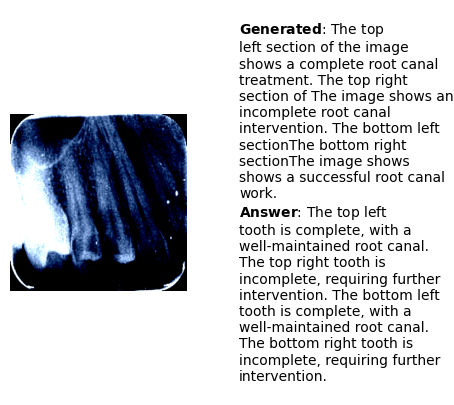

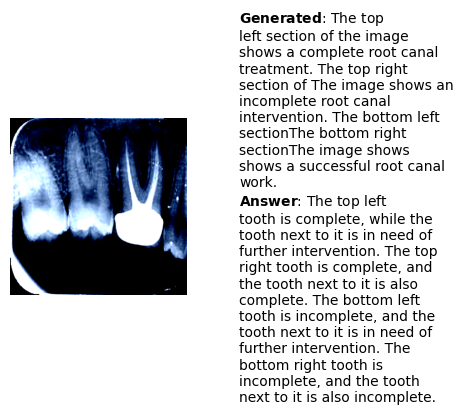

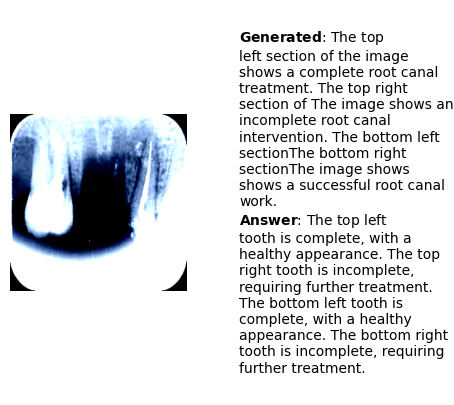

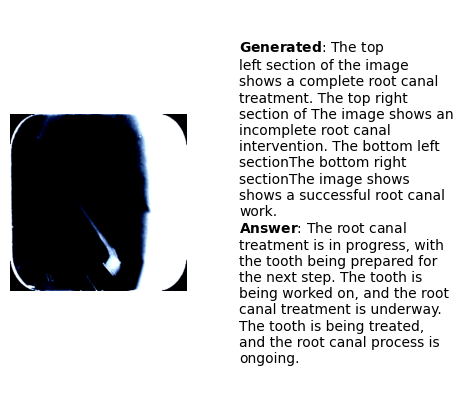

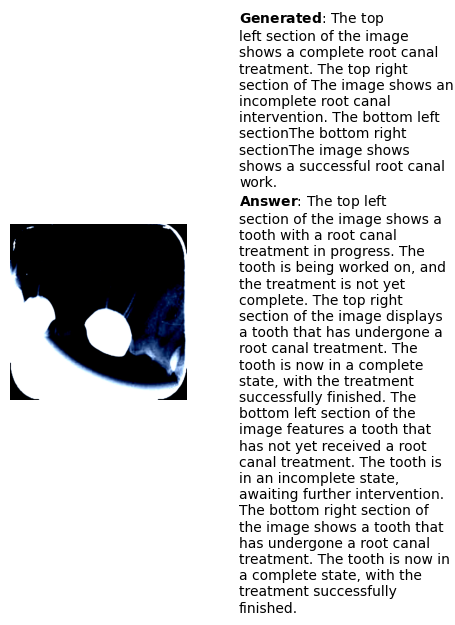

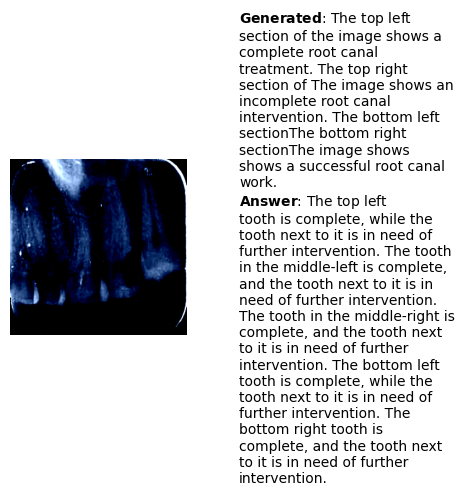

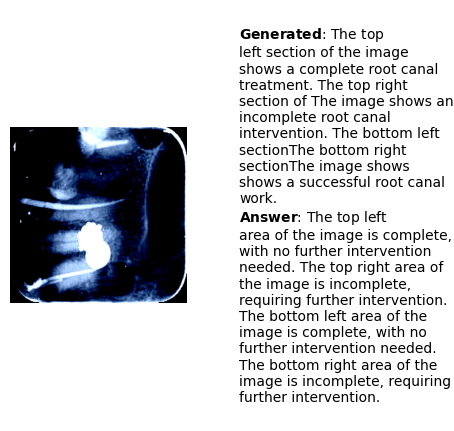

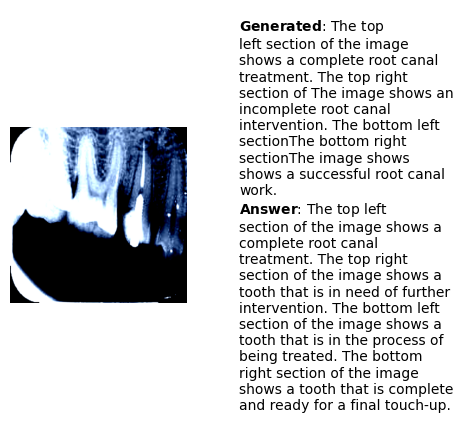

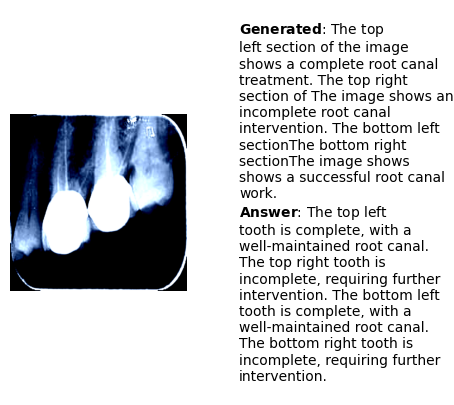

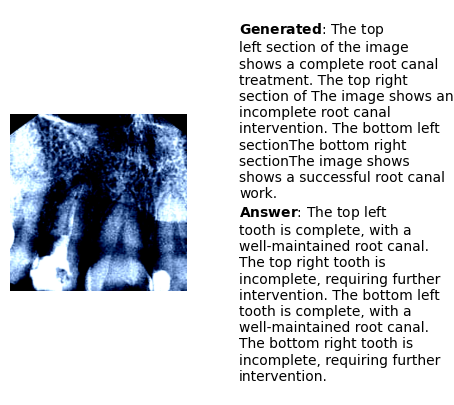

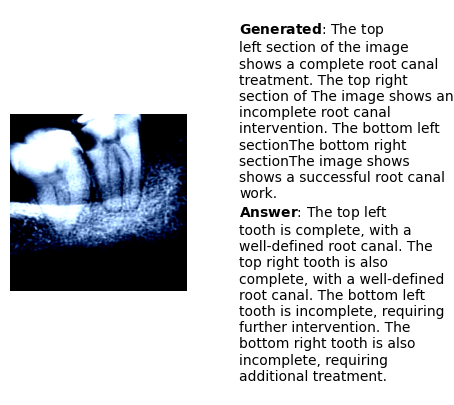

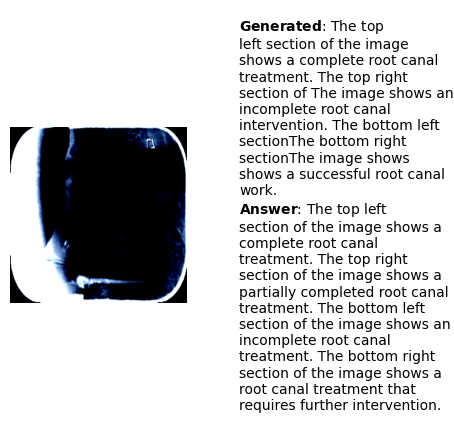

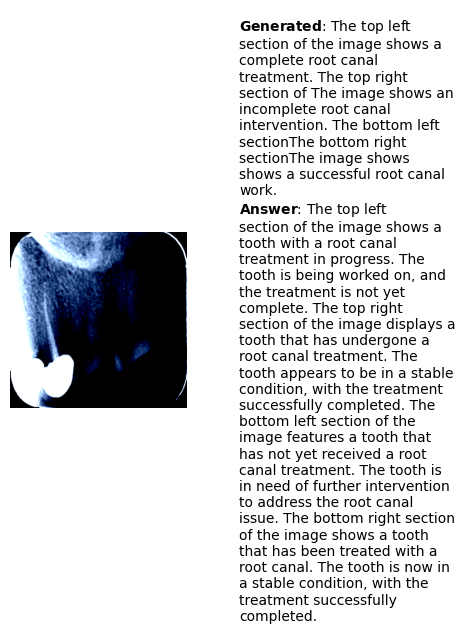

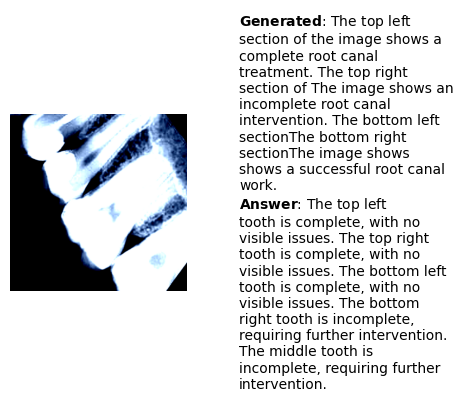

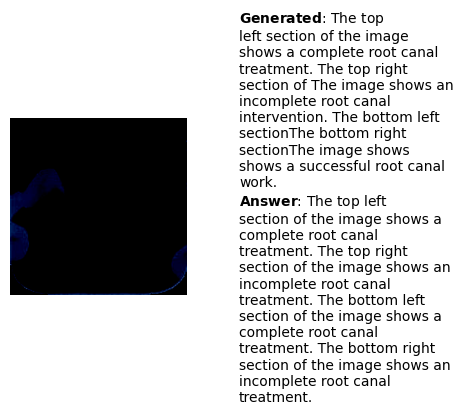

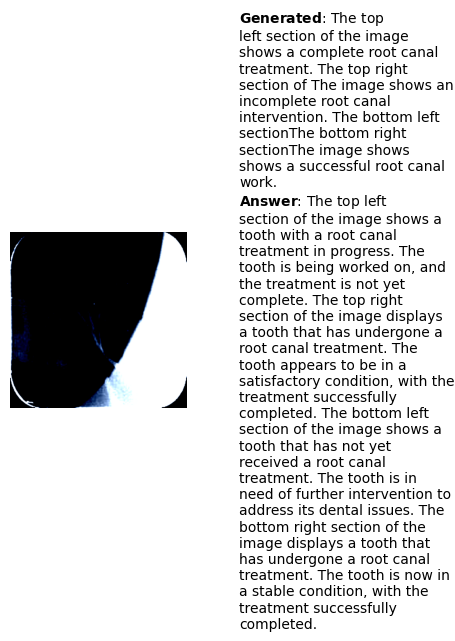

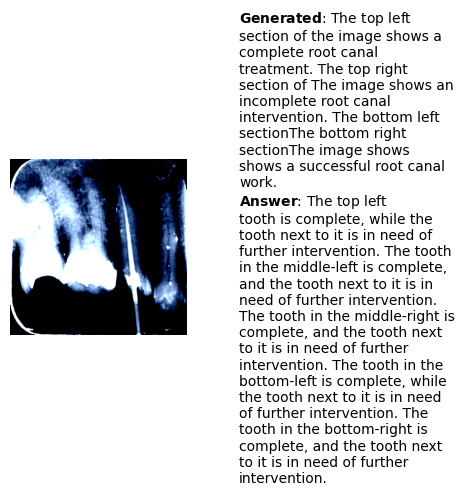

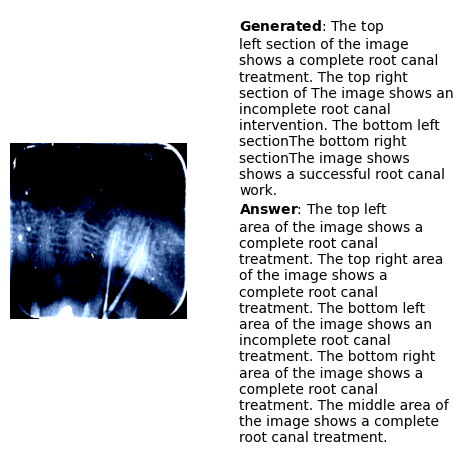

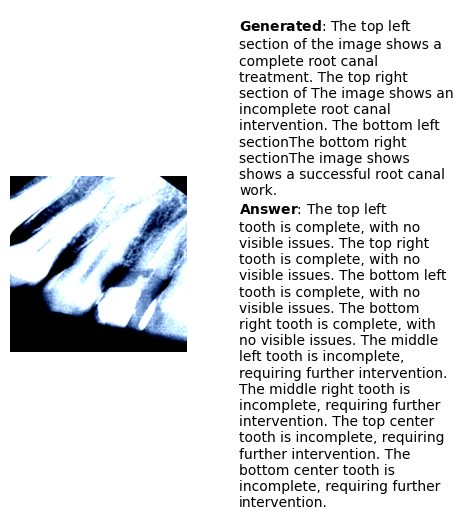

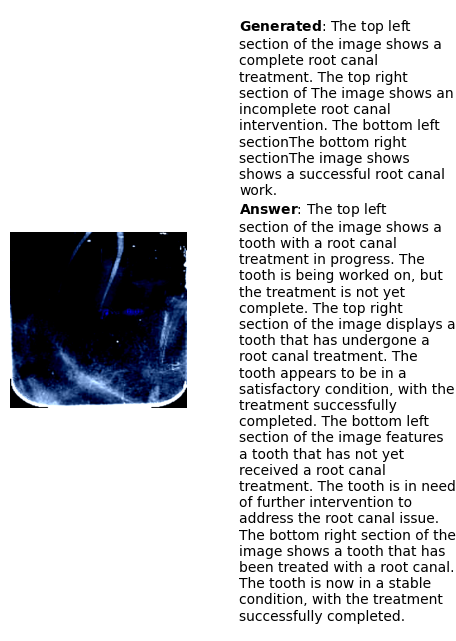

In [17]:
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

def run_inference(model, processor, data_loader, device):
    model.eval()
    results = []

    for inputs, answers in tqdm(data_loader, desc="Inference"):
        # Move tensors to device
        inputs = {
            key: value.to(device) if key != 'input_ids' else value.to(device).long()
            for key, value in inputs.items()
        }
        # Prepare decoder input ids
        decoder_input_ids = torch.full((inputs['input_ids'].shape[0], 1), processor.tokenizer.bos_token_id, dtype=torch.long, device=device)

        with torch.no_grad():
            # Generate captions
            generated_ids = model.generate(
                input_ids=inputs['input_ids'],
                pixel_values=inputs['pixel_values'],
                max_new_tokens=1024,
                num_beams=3
            )

        # Decode generated IDs to text
        generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

        # Collect results
        for pred, ans, img in zip(generated_texts, answers, inputs['pixel_values']):
            img = img.cpu().permute(1, 2, 0)  # Ensure image is in HWC format for display
            img = img.numpy()  # Convert tensor to numpy array
            results.append({'prediction': pred, 'answer': ans, 'image': img})

    return results

# Run inference on the validation dataset
val_results = run_inference(peft_model, processor, val_loader, DEVICE)

# Display answers and generated captions
for i, result in enumerate(val_results[:20]):
    plt.figure(figsize=(5, 5))

    # Display the image
    plt.subplot(1, 2, 1)
    plt.imshow(result['image'])
    plt.axis('off')
    plt.title(f"")

    # Display the generated caption
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.5, f"$\\bf{{Generated}}$: {result['prediction']}\n$\\bf{{Answer}}$: {result['answer']}",
             fontsize=10, ha='left', va='center', wrap=True)
    plt.axis('off')
    plt.title(f"")

    plt.show()


In [18]:
# Install all required packages
!pip install scikit-learn rouge-score git+https://github.com/salaniz/pycocoevalcap.git

# Download necessary NLTK data packages for BLEU and METEOR scores
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
import pycocoevalcap.bleu.bleu
import pycocoevalcap.meteor.meteor
import pycocoevalcap.cider.cider

# Prepare your predictions and references
predictions = [result['prediction'] for result in val_results]
references = [result['answer'] for result in val_results]

# Convert lists to dictionaries with image IDs as keys
gts = {i: [ref] for i, ref in enumerate(references)}
res = {i: [pred] for i, pred in enumerate(predictions)}

# Evaluate using BLEU Score
bleu_scorer = pycocoevalcap.bleu.bleu.Bleu(4)  # BLEU-4
bleu_score, _ = bleu_scorer.compute_score(gts, res)
print(f"BLEU Score: {bleu_score}")

# Evaluate using METEOR Score (from pycocoevalcap)
meteor_scorer = pycocoevalcap.meteor.meteor.Meteor()
meteor_score, _ = meteor_scorer.compute_score(gts, res)
print(f"METEOR Score: {meteor_score}")

# Evaluate using ROUGE Score
rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
num_samples = len(references)

for i in gts:
    scores = rouge_scorer_obj.score(gts[i][0], res[i][0])
    for rouge_key in rouge_scores:
        rouge_scores[rouge_key] += scores[rouge_key].fmeasure

# Average ROUGE Scores
for key in rouge_scores:
    rouge_scores[key] /= num_samples

print(f"ROUGE Scores: {rouge_scores}")

# Evaluate using CIDEr Score
cider_scorer = pycocoevalcap.cider.cider.Cider()
cider_score, _ = cider_scorer.compute_score(gts, res)
print(f"CIDEr Score: {cider_score}")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-bphis9zs
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-bphis9zs
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 6.5 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=b751b3f70ebe11e948ff819ab7d0649bce8c2491270f3f54bf2325b177c855c1
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312246 sha256=c3b10a7ff03c152f2064cc3fb776a19c5f0a46dc24eb5182e6ee49abf6e6bb33
  Stored in directory: /tmp/pip-ephem-wheel-cache-csvb4iyy/wheels/57/de/9f/7aa9a

In [19]:
# Install all required packages
!pip install scikit-learn rouge-score git+https://github.com/salaniz/pycocoevalcap.git autocorrect gensim

# Download necessary NLTK data packages
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

from autocorrect import Speller
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import pos_tag
from collections import Counter
import pycocoevalcap.bleu.bleu
import pycocoevalcap.meteor.meteor
import pycocoevalcap.cider.cider
from rouge_score import rouge_scorer
import re
import string

# Initialize spell checker, stemmer, and stop words
spell = Speller()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Function to perform spell correction
def correct_spelling(text):
    return spell(text)

# Function to expand common contractions
contractions = {
    "can't": "cannot", "won't": "will not", "n't": " not", "'re": " are", "'s": " is", "'d": " would", "'ll": " will", "'ve": " have", "'m": " am"
}

def expand_contractions(text):
    for contraction, full_form in contractions.items():
        text = re.sub(contraction, full_form, text)
    return text

# Function for POS filtering to retain meaningful words
def filter_pos(tokens):
    allowed_tags = {'NN', 'VB', 'JJ'}
    return [word for word, tag in pos_tag(tokens) if tag[:2] in allowed_tags]

# Function to remove low-frequency words based on a dataset-wide frequency count
def remove_low_frequency_words(tokens, frequency_dict, threshold=2):
    return [word for word in tokens if frequency_dict[word] > threshold]

# Preprocessing function with advanced techniques
def preprocess_text(text, frequency_dict):
    # Correct spelling errors
    text = correct_spelling(text)
    
    # Lowercase the text
    text = text.lower()

    # Expand contractions
    text = expand_contractions(text)
    
    # Remove digits
    text = re.sub(r'\d+', '', text)
    
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove punctuation and stop words
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    
    # POS filtering to retain nouns, verbs, adjectives
    tokens = filter_pos(tokens)

    # Apply stemming
    tokens = [stemmer.stem(word) for word in tokens]

    # Remove low-frequency words
    tokens = remove_low_frequency_words(tokens, frequency_dict)

    return ' '.join(tokens).strip()

# Build a frequency dictionary from your dataset
def build_frequency_dict(texts):
    all_words = []
    for text in texts:
        tokens = word_tokenize(text.lower())
        all_words.extend([word for word in tokens if word.isalpha()])
    return Counter(all_words)

# Prepare your predictions and references
predictions = [result['prediction'] for result in val_results]
references = [result['answer'] for result in val_results]

# Build frequency dictionary for low-frequency word removal
all_captions = predictions + references
frequency_dict = build_frequency_dict(all_captions)

# Preprocess predictions and references
preprocessed_predictions = [preprocess_text(pred, frequency_dict) for pred in predictions]
preprocessed_references = [preprocess_text(ref, frequency_dict) for ref in references]

# Convert lists to dictionaries with image IDs as keys
gts = {i: [ref] for i, ref in enumerate(preprocessed_references)}
res = {i: [pred] for i, pred in enumerate(preprocessed_predictions)}

# Evaluate using BLEU Score
bleu_scorer = pycocoevalcap.bleu.bleu.Bleu(4)  # BLEU-4
bleu_score, _ = bleu_scorer.compute_score(gts, res)
print(f"BLEU Score: {bleu_score}")

# Evaluate using METEOR Score
meteor_scorer = pycocoevalcap.meteor.meteor.Meteor()
meteor_score, _ = meteor_scorer.compute_score(gts, res)
print(f"METEOR Score: {meteor_score}")

# Evaluate using ROUGE Score
rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
num_samples = len(preprocessed_references)

for i in gts:
    scores = rouge_scorer_obj.score(gts[i][0], res[i][0])
    for rouge_key in rouge_scores:
        rouge_scores[rouge_key] += scores[rouge_key].fmeasure

# Average ROUGE Scores
for key in rouge_scores:
    rouge_scores[key] /= num_samples

print(f"ROUGE Scores: {rouge_scores}")

# Evaluate using CIDEr Score
cider_scorer = pycocoevalcap.cider.cider.Cider()
cider_score, _ = cider_scorer.compute_score(gts, res)
print(f"CIDEr Score: {cider_score}")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-gjej_qst
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-gjej_qst
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 42.0 MB/s eta 0:00:00
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=7e891ada204766055173031cbcc4e223e1794f35af13a8d5760e869a7d08fc12
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect
  Attempting uninstall: scipy
    Found existing insta